# Kraken Flex Dynamic Containment Task Thomas Madeley

**Instructions**

Comprehensive instructions on how to create a suitable Conda environment to run this notebook can be found in the `readme.md`.

## Task

The full task summary can be found in the brief: `Data Science Interview Task 2021.pdf` in the main repo. 

In this brief, we were tasked with modeling a proposed Dynamic Containment service, analyzing the performance of a given grid battery over time. 

We have been provided with a subsample of grid frequency data at 1Hz intervals, a formula to describe the dynamic containment strategy and the specifications of a grid battery.  with which to do this

The goal was to understand the battery's state of charge (SOC) behavior, the longest expected service duration without hitting constraints, and to provide recommendations on the most suitable service type.




## TL;DR, Give Me A Brief Summary

To model and analyze the performance of the grid battery under different dynamic containment services, we followed a statistical approach using Monte Carlo simulations:

- We started by loading and inspecting the provided frequency dataset to understand its characteristics. We found it to be partially complete and that the distribution of deviations from 50Hz was approximately normally distributed with caveats (see section 4.)
- Next, we fitted a distribution to the frequency deviation data to model the variations statistically. We experimented with a Gaussian Mixture Model to account for Bimodality but found a basic normal distribution fit better.
- A Python class was developed to simulate the behavior of the grid battery, incorporating its charging and discharging mechanisms as specified by the parameters in the brief by default, but this can be tweeked and re-used. 
- The dynamic containment strategy was implemented as a function to determine power demand based on frequency deviations.
- Using a Monte Carlo simulation approach, we performed numerous simulations to estimate the battery's performance over time. Unfortunately my local hardware meant I was unable to run lots of simulations but I hope I proved the concept and adequately explain *how* I would scale this up given more time and a big EC2 instance! (See section 8 for full analysis). 
- Finally, we analyzed the results to determine the battery's state of charge, the longest expected service duration, and recommended the most suitable service type based on the simulation outcomes.

I had a lot of fun learning about dynamic containment and exploring some statistical methods, I hope you enjoy reading my submission 😀

**TL;DR Results**

1. **State-of-charge behavior when running the 'both' DC service:**
   - At all service power levels, the mean SOC gradually declines over time due to charging losses, even though the battery is being charged and discharged at approximately equal rates.

2. **Longest expected service duration without hitting limits:**
   - Based on the assumptions of our model and simulations, using only 5 simulations and commencing the battery SOC at 99%, we achieved the following mean durations to reach 0% SOC:
     - 2 MW: 324.94 days
     - 5 MW: 129.56 days
     - 10 MW: 64.86 days
   - Running thousands of simulations would provide more accurate estimates, confidence intervals, and insights into the battery's performance variability.
   - Both the 2MW and 5MW services can be safely run for an extended period without running into power limitations, but the 5MW service could potentially run into power limitations as the full service power is greater than the battery's maximum charge rate.
   - The 10MW service did run into a power limitation where the requested input from the grid exceeded the available power from the battery.

3. **Recommendations on running high, low, both services with different battery sizes:**
   - A 'Both' service will inevitably result in an empty battery due to charging losses over a long period of time.
   - A 'High' service will inevitably result in a full battery within days.
   - A 'Low' service will inevitably result in an empty battery within days.
   - There seems to be little benefit in running a 'low' service when a 'both' service can handle all of the simulated charge and discharge demand.
   - If we had several batteries, we could offer both 'High' and 'Both' services in conjunction, rotating batteries to allow adequate time for the 'Both' service to discharge our battery, then switch it to a 'high' service to recoup the lost charge. With some optimization, this would allow us to meet all of the grid's demands whilst never incurring an empty or full SOC in the battery.



## If I Had More Time

- There are obviously many ways this analysis could be taken. I would have liked to have explored a Monte Carlo Markov Chain (MCMC) approach to the problem. The basic Monte Carlo implementation here ignores the fact that the next frequency deviation is closely related to the current one, I feel this may have yielded a more accurate result with less simplification of the problem: In my implementation we have effectively assumed that the deviation is random. Similarly, Bayesian methods may work well here but this is somewhat outside my comfort zone. 

- I would have liked to have moved functions and classes into appropriate modules in the repository, with proper testing and error handling. This would make the notebook much more readable. Naturally this is a time limited task and these things are out of scope. There is far too much logic in this notebook to go untested!

- A simple improvement here would to create functions to create the plots, this would reduce code duplication and clutter in the notebook.

- I would have liked to have implemented a multi-processing approach to the monte carlo simulations to speed up the simulations to enable me to perform more. This would really improve the quality of the results (see section 8) and would have allowed me to give ranges of values with confidence intervals to better inform decisions.

- Similarly, I would have liked to use our deviation distribution to calculate the probabilities of encountering a power limit at 5MW and 10MW for both charging and discharging as described in section 8.

## Process/ Contents

2. Loading Dataset
3. EDA
4. Finding a distribution to model the frequency data
5. Modeling the grid battery with a Python Class
6. Modeling the Dynamic Containment Service with a function
7. Creating a function to perform Monte Carlo Simulations
8. Running the simulations and Analysis


In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy import stats
from scipy.stats import norm
from sklearn.mixture import GaussianMixture

from typing import Tuple, Dict, Any

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

In [77]:
# Magic Command to navigate out of the notebook directory into the main directory of the project. You may need to alter this based on your setup
%cd ..

/Users/tmadeley/Documents


/Users/tmadeley/miniconda3/envs/kraken_dc/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


# Loading & Inspecting the dataset

- The dataset is loaded and the datetimes are parsed with the expected format (as given in the brief).

In [3]:
data = pd.read_csv(
    "data/task_data_1hz.csv", parse_dates=["datetime"], date_format="ISO8601"
)

data.head()

,datetime,f_hz
0,2021-09-01 00:00:00,49.922
1,2021-09-01 00:00:01,49.917
2,2021-09-01 00:00:02,49.909
3,2021-09-01 00:00:03,49.903
4,2021-09-01 00:00:04,49.899


# EDA

Let's do some basic EDA to check our data for completeness and to understand it a little further. 


- We have around 2.5 Million rows of data.
- The data types appear to be inferred correctly: Datetime and float.

- The mean grid frequency in the data is exactly 50hz so it appears the containment strategies seem to work!
- The standard deviation of the grid frequencies is very small (0.06hz) meaning the grid frequencies appear to be very tightly grouped around 50hz as we would expect.
- There appears to be higher peaks of over generation (51.2hz or + 1.2hz) vs troughs of under generation (49.7hz or -0.3hz).
    - We will dig into this further when we look at the distribution and time series of frequencies
 
**Nulls**
- **32.5% of the frequency values are null.** We will have to investigate further and consider whether we should do some kind of imputation.
    - We appear to have data for approximately 1 month (September 2021)
- Although none of the datetime values were null, we decided to check the time series was complete between the max and min.
    - We found that it is: we have 1 row for every second between the min and max timestamps. 

In [4]:
# Dataframe info, dtypes and shape.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2528300 entries, 0 to 2528299
Data columns (total 2 columns):
 #   Column    Dtype         
---  ------    -----         
 0   datetime  datetime64[ns]
 1   f_hz      float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 38.6 MB


In [5]:
# Summary Statistics
data.describe()

,datetime,f_hz
count,2528300,1.707500e+06
mean,2021-09-15 15:09:09.500007680,5.000101e+01
min,2021-09-01 00:00:00,4.971800e+01
25%,2021-09-08 07:34:34.750000128,4.995600e+01
50%,2021-09-15 15:09:09.500000,5.000000e+01
75%,2021-09-22 22:43:44.249999872,5.004600e+01
max,2021-09-30 06:18:19,5.128600e+01
std,NaN,5.998095e-02


## Investigating any Null values

In [6]:
# Calculate percentage of nulls
null_percentage = data.isnull().sum() / data.shape[0] * 100

# Create a new DataFrame with null percentages
null_df = pd.DataFrame(null_percentage, columns=["null_percentage"])

null_df

,null_percentage
datetime,0.000000
f_hz,32.464502


In [7]:
# Define start_date and end_date
start_date = data.datetime.min()
end_date = data.datetime.max()

complete_range = pd.date_range(start=start_date, end=end_date, freq="s")

existing_dates_set = set(data["datetime"])

# Check if complete_range matches existing_dates_set
if set(complete_range) == existing_dates_set:
    print(
        "The datetime column is complete between {} and {}.".format(
            start_date, end_date
        )
    )
else:
    print(
        "The datetime column is not complete between {} and {}.".format(
            start_date, end_date
        )
    )

The datetime column is complete between 2021-09-01 00:00:00 and 2021-09-30 06:18:19.


## Visualising the Data



### Frequency Over Time
- There are several gaps in the available data corresponding to the null values in our frequency column identified earlier.
- It appears the null values are confined to several distinct time periods (as marked in red on the below chart).
- There appears to be three significant positive outliers where the frequency rises above 50.5hz.
    - In reality, we would use domain knowledge or talk with stakeholders to determine whether these are true outliers, equipment errors or within an expected range of high energy generation.
    - That they are extremely 'steep' means the high generation was not sustained for more than 1 or 2 seconds, this *could* be a faulty reading or perhaps sharp spikes like this are expected and relatively normal: again domain knowledge would come in to play here. 

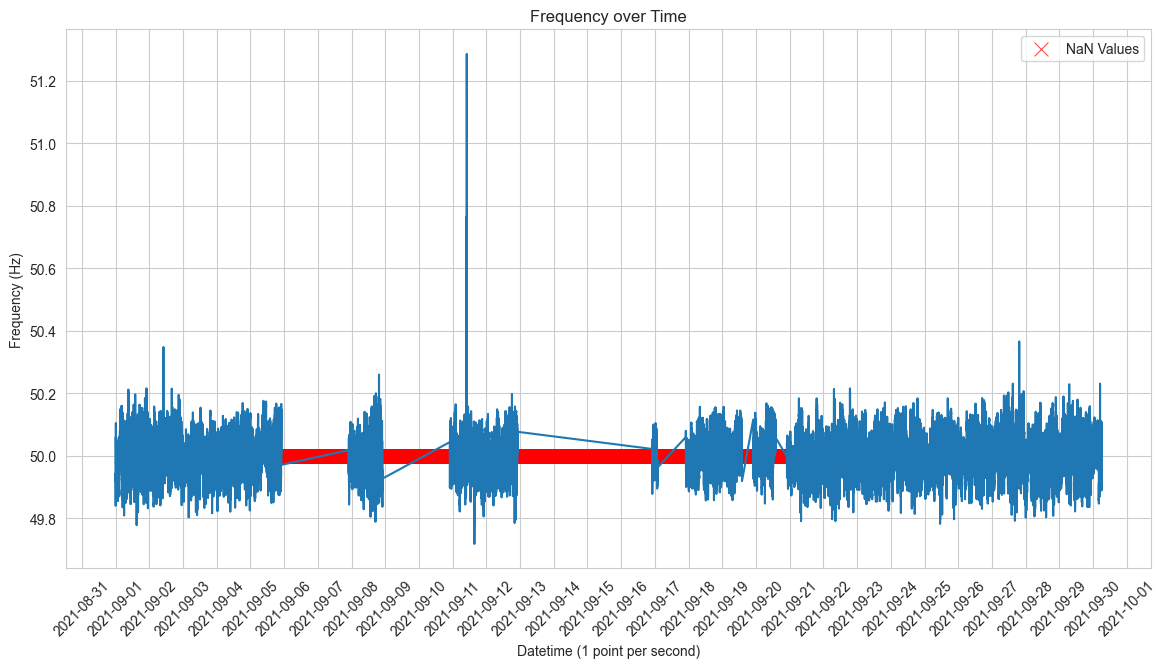

In [8]:
plt.figure(figsize=(14, 7))

sns.lineplot(data=data, x="datetime", y="f_hz")

# Mark NaN values with a scatter plot at y=50
sns.scatterplot(
    data=data[data["f_hz"].isnull()],
    x="datetime",
    y=[50] * data["f_hz"].isnull().sum(),
    color="red",
    marker="x",
    s=100,
    label="NaN Values",
    alpha=0.7,
)

# Set X-ticks to daily
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))

plt.xlabel("Datetime (1 point per second)")
plt.ylabel("Frequency (Hz)")
plt.title("Frequency over Time")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()

### Examining the Positive Outlier(s)
- All of the very high outliers occur within a 4 minute window.
- This could indicate that this is some non random over generation event
- We are going to make the assumption that these are valid readings that are within expected ranges and **retain** these points. 

,datetime,f_hz
898721,2021-09-11 09:38:41,50.747
898722,2021-09-11 09:38:42,50.765
900129,2021-09-11 10:02:09,51.286


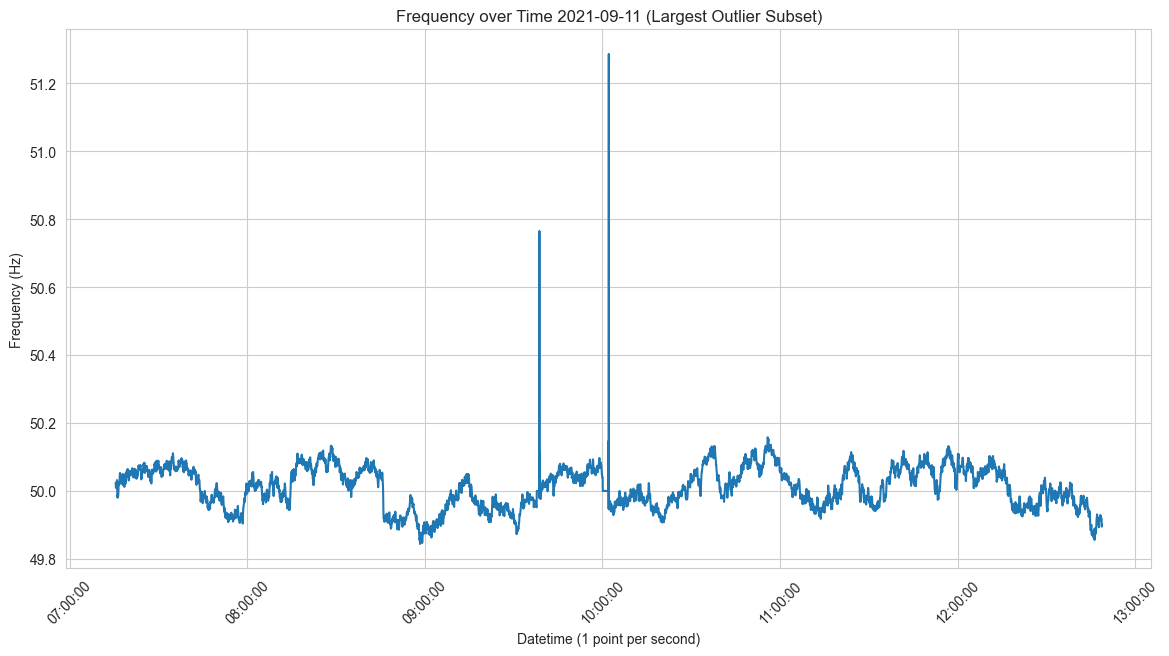

In [9]:
### Examining the steep rise in generation of the highest outlier value
display(data[data.f_hz > 50.4])

# Plotting
plt.figure(figsize=(14, 7))

# Selecting the period immediately around the largest outliers
outlier_data = data.iloc[900129 - 10000 : 900129 + 10000]

# Line plot of Frequency over Time
sns.lineplot(data=outlier_data, x="datetime", y="f_hz")
plt.xlabel("Datetime (1 point per second)")
plt.ylabel("Frequency (Hz)")
plt.title("Frequency over Time 2021-09-11 (Largest Outlier Subset)")

# Set the x-axis major locator to minutes
plt.gca().xaxis.set_major_locator(mdates.HourLocator())
# Set the x-axis major formatter to show minutes and seconds
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M:%S"))

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

plt.show()

### Examining the distribution of deviations

We wanted to examine the distribution of the frequencies to help us decide on how best to model the problem. 

Lets center the data around 0, by calculating the deviations from the expected frequency. (This doesn't actually change the distribution, just moves it). 

We additionally removed the 3 very high deviations from the visualisation to improve readability. 

- The distribution appears to **close** to a normal distribution, with the points being symmetrically distributed around the mean frequency deviation (0Hz)
- That the mean is very close to 0Hz implies the grid's current management strategies are working! It is however, slightly positive.
- The 'bell curve' appears to drop away smoothly in either direction to values of around -0.2Hz and 0.2Hz with a very small number of values beyond these values. 
- The distribution is **bimodal** with peaks either side of the mean value. This may warrant further investigation.
    - This may indicate that there are two different operating regimes or states where the grid frequency seems to deviate from the 50Hz target which could be consistent with:
    - **Under Generation State** Where the grid requires more generation to restore the frequency to 50Hz
    - **Over Generation State** Where the grid requires less generation/more usage to restore the frequency to 50Hz.
    - This could make it slightly trickier to build a statistical model: Perhaps we can't just use a normal distribution.
    - **Or this difference may not actually be statistically significant.** 
      

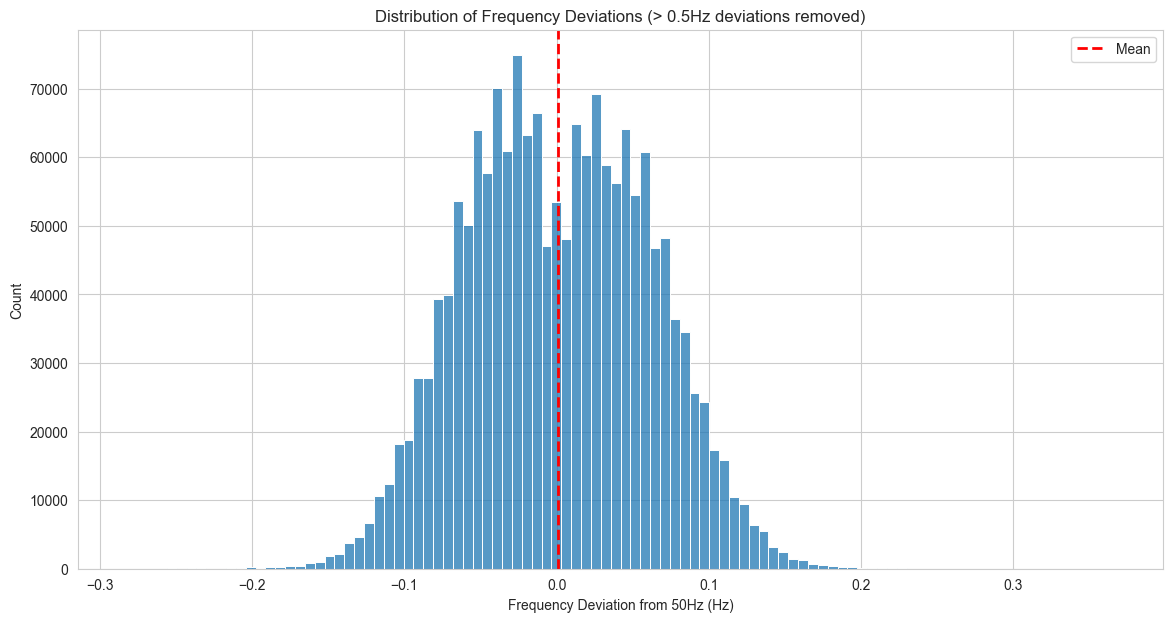

In [10]:
# Calculate deviation from 50hz
data["deviations"] = data["f_hz"] - 50
data.dropna(subset=["f_hz"], inplace=True)

# Calculate mean
mean = data["deviations"].mean()

large_deviations_removed = data[data["deviations"] < 0.5]

# Plotting the distribution
plt.figure(figsize=(14, 7))
sns.histplot(large_deviations_removed["deviations"], bins=100, kde=False)
plt.xlabel("Frequency Deviation from 50Hz (Hz)")
plt.title("Distribution of Frequency Deviations (> 0.5Hz deviations removed)")

# Add mean line
plt.axvline(mean, color="red", linestyle="--", linewidth=2, label="Mean")

plt.legend()

plt.show()

# Finding a Suitable Distribution To Model the Data

**Decision from analysis**
- We chose to represent the data using a simple normal distribution.
- The GMM disitribution fit was visually very good, however the Q-Q plot was not as good as the normal distribution.
- In a real project, we would probably proceed with both and experiment further. 


## Normal Distribution

The data looks very close to a normal distribution however it does have some bimodality (two peaks).

As a result of this we will try to attempt to model the data using a normal distribution first as this represents a very simple solution, that's easy to understand and should generalise well. 

We are introducing some additional assumptions to those mentioned above here:


- Normality,we are assuming that the data is normally distributed, follows a bell shaped curve. 
- The data comes from a single population and has no multimodality which we saw is not strictly true but we *could* over look this if the fit is very good.
- We are estimating the parameters for the entire population (ie all of the frequencies ever recorded) based on our sample of data.


### Fitting Process

- We use scipy.stats to fit a normal distribution to our data, this use an MLE estimate the mean and standard deviation of the disitribution, but the result is almost identical to using the mean and standard deviation of our data.
- We perform a Kolmogorov–Smirnov test on the fitted disitribtuion against our data to test how well the estimated normal distribution fits our data.
- We achieve a very low P value and therefore the disitribution fits very well.
- We further check the fit by plotting a Q-Q plot. The Q-Q plot is a measure of how well our theoretical distribution matches the distribution of our underlying data. We want see all of our points directly on our horizontal line indicating perfect agreement between the estimated distribution and the real one.
    - The Q-Q plot indicates a very strong fit for the vast majority of the range with some outliers in the right tail, which we might expect to see given our very large outliers identified earlier.  
- Finally we plot the estimated distribution over the histogram of our real data.
    - This shows a very close fit to the data however, the normal distribution over estimates the density around our mean frequency.
    - It fails to account for the bimodality of our data as expected. 


Normal Distribution fitted with mean:0.001010777745241588 and std dev:0.05998093567627596
Normal K-S Test: D=0.035847808525729, p-value=0.0


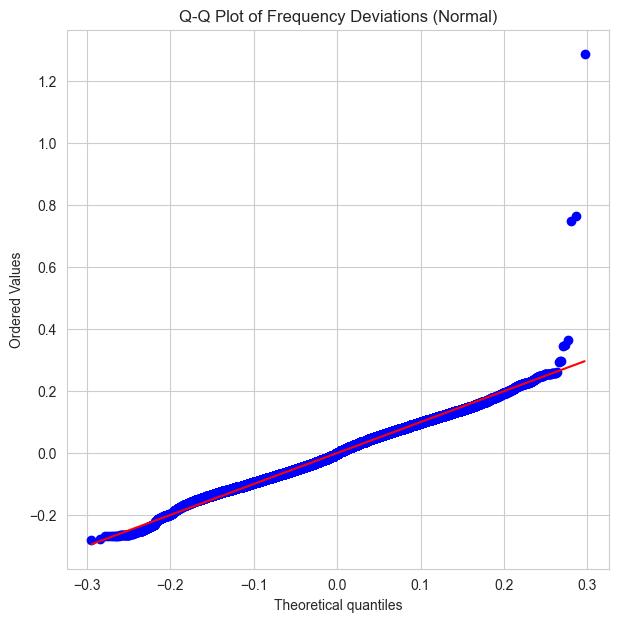

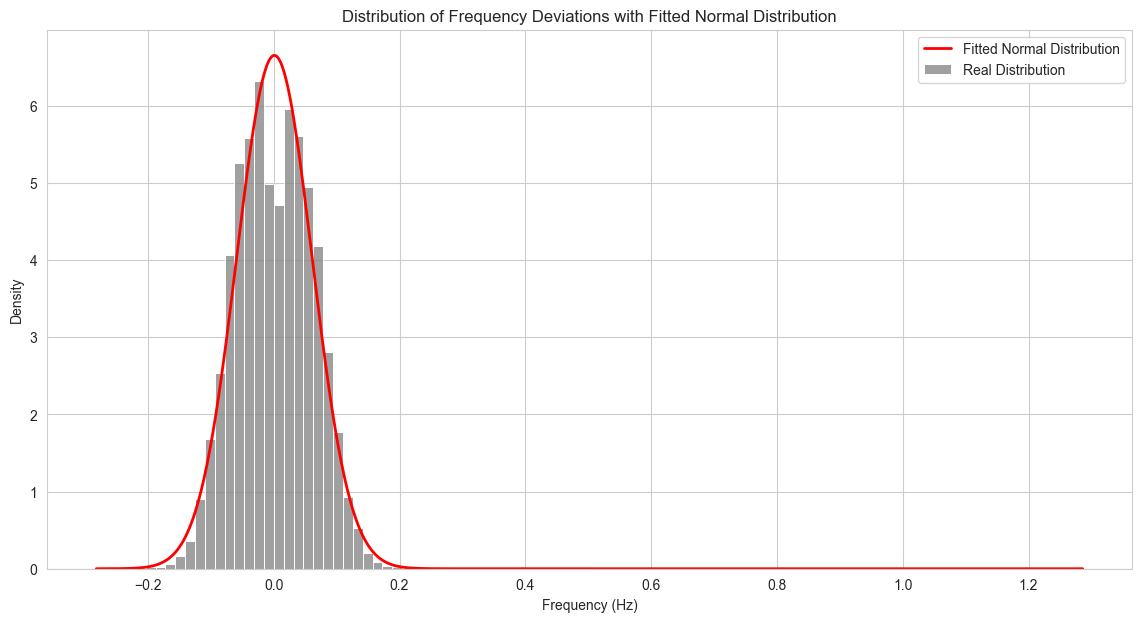

In [46]:
# Fit a normal distribution
norm_params = stats.norm.fit(data["deviations"])
norm_ks_test = stats.kstest(data["deviations"], "norm", norm_params)
print(
    f"Normal Distribution fitted with mean:{norm_params[0]} and std dev:{norm_params[1]}"
)

# Print K-S test results
print(f"Normal K-S Test: D={norm_ks_test.statistic}, p-value={norm_ks_test.pvalue}")

# Plot Q-Q plot for normal distribution
plt.figure(figsize=(7, 7))
stats.probplot(data["deviations"], dist="norm", sparams=norm_params, plot=plt)
plt.title("Q-Q Plot of Frequency Deviations (Normal)")
plt.show()

# Extract mean and standard deviation from the fitted parameters
mean, std_dev = norm_params

# Plot the real distribution
plt.figure(figsize=(14, 7))
sns.histplot(
    data["deviations"],
    bins=100,
    kde=False,
    color="gray",
    stat="density",
    label="Real Distribution",
)

# Define x range for the PDF
x = np.linspace(data["deviations"].min(), data["deviations"].max(), 1000)

# Plot the PDF of the fitted normal distribution
plt.plot(
    x,
    stats.norm.pdf(x, mean, std_dev),
    color="red",
    linewidth=2,
    label="Fitted Normal Distribution",
)

plt.xlabel("Frequency (Hz)")
plt.ylabel("Density")
plt.title("Distribution of Frequency Deviations with Fitted Normal Distribution")
plt.legend()
plt.show()

## Gaussian Mixture Model

Let's try and use an alternative technique to appropriately model the bimodality of the data. 

As mentioned earlier, it appears we have two distinct, overlapping 'states' in our system **over generation** and **under generation**. Each of the two states appears to be somewhat normally distributed. This led us to think of a Gaussian Mixture Model (GMM). GMM's allows us to create aggregated disitributions that are made up of a weighted sum of a number of component gaussian distributions: in our case we can train one with two components. 

We are introducing some additional assumptions to those mentioned above here:

- Normality of the GMM component disitributions. 
- That the data can be represented by a known number of gaussian components (in our case it looks like we have two) and that each component represents a sub-population.
- The overall distribution of the data is assumed to be a mixture of several normal distributions. This means the overall density function is a weighted sum of the individual normal densities of the components.


Parameters for the GMM (means, variances, and weights) and the single normal distribution are estimated from the data using maximum likelihood estimation (MLE). This assumes that the model that maximizes the likelihood function is the best fit for the data.

### Fitting Process

- We use sklearn.mixture to fit a GMM to our data using 2 components, this use an MLE estimate the mean and standard deviation of the component disitributions as well as weights and covariances to determine how they interact. 
- We can't directly perform a Kolmogorov–Smirnov test on a GMM so we have to rely on visual 'goodness of fit' measures.
- The fit of the Q-Q plot is visually good but perhaps not as good as the normal distribution.
    - We get significant deviation from the line at either tail which may indicate that our bimodal GMM does not fit the true data as well as the previous normal distribution. Perhaps the bimodality is not as significant as we thought?
 
- Finally we plot the estimated GMM distribution over the histogram of our real data and included the two component distributions.
    - The GMM successfully captures the bimodality of our data.  
    - The visual fit is very good.
    - That the component distributions don't quite meet the two peaks of our data shows the additive nature of a GMM.
        - The peaks are the peak of the respective component + part of the tail of the other component. 


GMM Means: [-0.04343025  0.04641057]
GMM Covariances: [0.00153557 0.00162761]
GMM Weights: [0.50533592 0.49466408]


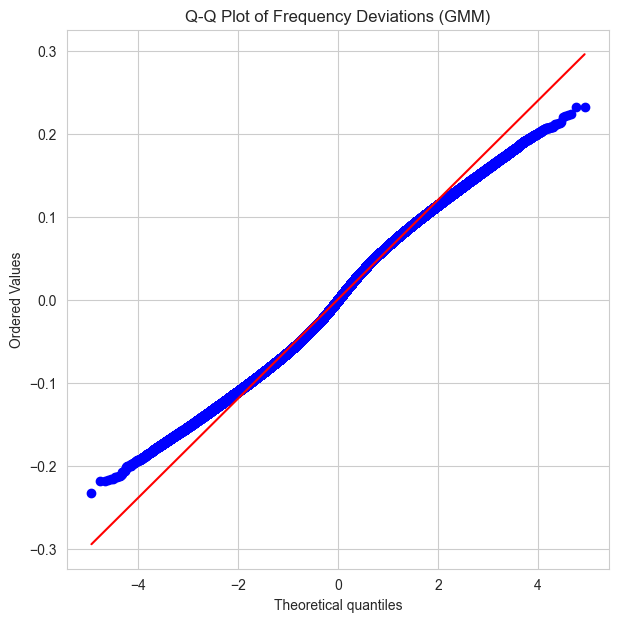

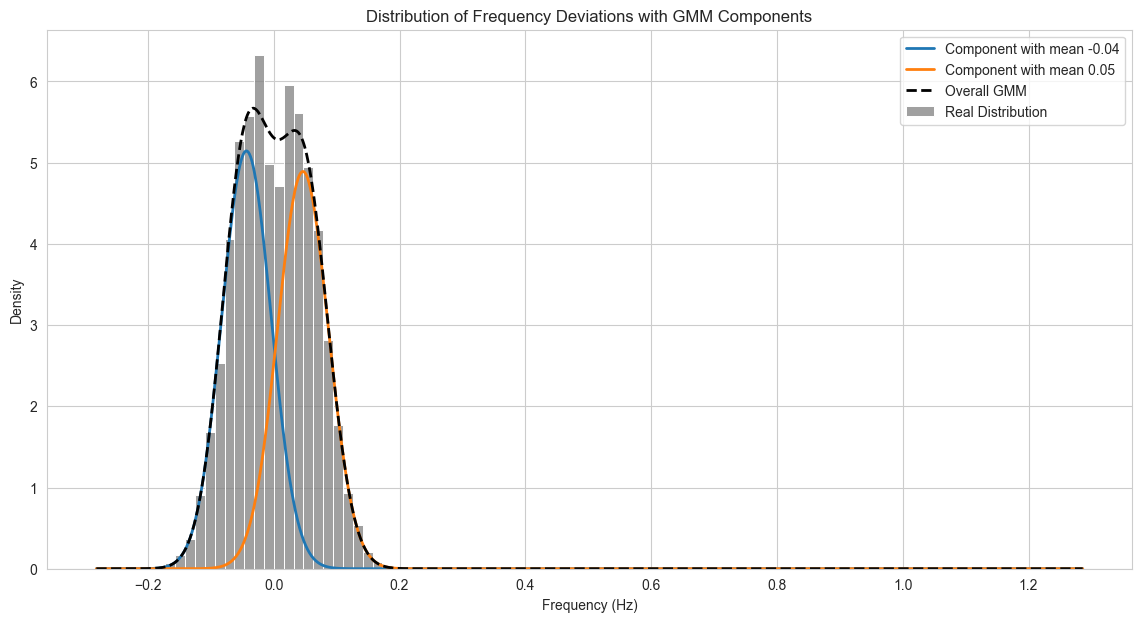

In [12]:
# Fit a Gaussian Mixture Model
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(data["deviations"].values.reshape(-1, 1))

# Get GMM parameters
gmm_means = gmm.means_.flatten()
gmm_covariances = gmm.covariances_.flatten()
gmm_weights = gmm.weights_.flatten()

# Print GMM parameters
print(f"GMM Means: {gmm_means}")
print(f"GMM Covariances: {gmm_covariances}")
print(f"GMM Weights: {gmm_weights}")

# Generate Q-Q plot for GMM
sampled_deviation = gmm.sample(n_samples=len(data))[0].flatten()
plt.figure(figsize=(7, 7))
stats.probplot(sampled_deviation, dist="norm", plot=plt)
plt.title("Q-Q Plot of Frequency Deviations (GMM)")
plt.show()

# Plot the real distribution
plt.figure(figsize=(14, 7))
sns.histplot(
    data["deviations"],
    bins=100,
    kde=False,
    color="gray",
    stat="density",
    label="Real Distribution",
)

# Define x range for the PDFs
x = np.linspace(data["deviations"].min(), data["deviations"].max(), 1000)

# Plot the PDFs of the two GMM components
for mean, cov, weight in zip(gmm_means, gmm_covariances, gmm_weights):
    plt.plot(
        x,
        weight * norm.pdf(x, mean, np.sqrt(cov)),
        label=f"Component with mean {mean:.2f}",
        linewidth=2,
    )

# Plot the overall GMM PDF
overall_gmm_pdf = np.sum(
    [
        weight * norm.pdf(x, mean, np.sqrt(cov))
        for mean, cov, weight in zip(gmm_means, gmm_covariances, gmm_weights)
    ],
    axis=0,
)
plt.plot(
    x, overall_gmm_pdf, color="black", linestyle="--", label="Overall GMM", linewidth=2
)

plt.xlabel("Frequency (Hz)")
plt.ylabel("Density")
plt.title("Distribution of Frequency Deviations with GMM Components")
plt.legend()
plt.show()

# Modeling The Grid Scale Battery

We have a battery with a set of capabilities and attributes, we also have a state of charge to monitor over time. This led us to think a class would be the optimal way to model this in code. In a real project we would likely add this to the main repository with appropriate tests and error handling, but we will create it in this notebook for speed. 

Below we have defined a re-usable class for our battery that we can use in our simulations. 

The class has attributes to represent the batteries properties as outlined in the brief by default. The actual values can be inserted when the class is initialised. 

We have added functions for charging and discharging the battery at a given power for a given time period. Both of these functions prevent charging or discharging the battery at a rate higher than the maximum allowed rates. They also raise an error if the battery reaches an empty or full state. 

In [13]:
class FullBatteryException(Exception):
    """Exception raised when the battery reaches max capacity."""

    pass


class EmptyBatteryException(Exception):
    """Exception raised when the battery is empty."""

    pass


class Battery:
    def __init__(
        self,
        capacity_mwh: int = 4,
        initial_soc: float = 0.5,
        max_discharge_mw: int = 5,
        max_charge_mw: int = 4,
        efficiency: float = 0.9,
    ):
        """
        Initialize the Battery object with the specified parameters.

        Parameters
        ----------
        capacity_mwh : int
            Total capacity of the battery in MWh.
        initial_soc : float
            The initial charge state of the battery in percent.
        max_discharge_mw : int
            Maximum discharge rate in MW.
        max_charge_mw : int
            Maximum charge rate in MW.
        efficiency : float
            Efficiency of the battery applied to both charging and discharging (0-1).
        """
        self.capacity_mwh = capacity_mwh
        self.max_discharge_mw = max_discharge_mw
        self.max_charge_mw = max_charge_mw
        self.efficiency = efficiency
        self.state_of_charge_mwh = capacity_mwh * initial_soc

    def charge(self, power_mw, duration_seconds):
        """
        Add charge to the battery.

        The requested charge power will be scaled down by the battery efficiency: 1MW charge actually charges at 0.9MW.

        Parameters
        ----------
        power_mw : float
            Power to charge the battery in MW.
        duration_seconds : int
            Duration of charging in seconds.

        Raises
        ------
        FullBatteryException
            If the battery is at 100% charge, end the simulation.
        """
        duration_hours = duration_seconds / 3600.0
        effective_power = min(power_mw, self.max_charge_mw) * self.efficiency
        energy_added = effective_power * duration_hours
        # Prevent overcharging
        self.state_of_charge_mwh = min(
            self.state_of_charge_mwh + energy_added, self.capacity_mwh
        )
        if self.state_of_charge_mwh == self.capacity_mwh:
            raise FullBatteryException("Battery is at 100% charge, ending simulation")

    def discharge(self, power_mw, duration_seconds):
        """
        Discharge the battery.

        The requested discharge power is assumed to be 100% efficient.

        Parameters
        ----------
        power_mw : float
            Power to discharge the battery in MW.
        duration_seconds : int
            Duration of discharging in seconds.

        Raises
        ------
        EmptyBatteryException
            If the battery is at 0% charge, end the simulation.
        """
        duration_hours = duration_seconds / 3600.0
        effective_power = min(power_mw, self.max_discharge_mw)
        energy_removed = effective_power * duration_hours
        # Prevent negative SOC
        self.state_of_charge_mwh = max(self.state_of_charge_mwh - energy_removed, 0)
        if self.state_of_charge_mwh == 0:
            raise EmptyBatteryException("Battery is at 0% charge, ending simulation")

    def get_state_of_charge(self):
        """
        Get the current state of charge of the battery in MWh.

        Returns
        -------
        float
            Current state of charge in MWh.
        """
        return self.state_of_charge_mwh



# Lets test the class...
battery = Battery(
    capacity_mwh=4, initial_soc=0.5, max_discharge_mw=5, max_charge_mw=4, efficiency=0.9
)

# Charge the battery at 2MW for 1 hour
battery.charge(power_mw=2, duration_seconds=3600)
print(f"State of Charge after charging: {battery.get_state_of_charge()} MWh")

# Discharge the battery at 3MW for 10 seconds
battery.discharge(power_mw=3, duration_seconds=10)
print(f"State of Charge after discharging: {battery.get_state_of_charge()} MWh")


# Lets fully discharge the battery and test the exception..
battery.discharge(power_mw=4, duration_seconds=36000)
print(f"State of Charge after discharging: {battery.get_state_of_charge()} MWh")

State of Charge after charging: 3.8 MWh
State of Charge after discharging: 3.7916666666666665 MWh


EmptyBatteryException: Battery is at 0% charge, ending simulation

# Modelling the DC Service Demand

We now need a function to calculate the demand from the battery based on the frequency deviation. We have been given a response curve in the brief and we can simply write a function to calculate this for a given frequency deviation and service power. 


In the below function we configure the response curve with a small configuration dictionary, then our function calculates the power demand using the configuration and service power. 



In [14]:
# Configuration of dynamic containment service.
dc_conf = {"deadband": 0.015, "elbow": 0.2, "full_response": 0.5}


def calculate_power_demand(
    deviation: float, service_power: int, service_type: str, dc_conf: Dict[str, float]
) -> float:
    """
    Calculate power demand based on frequency deviation and service power.

    Parameters
    ----------
    deviation : float
        Frequency deviation from 50Hz.
    service_power : float
        Service power in MW.
    service_type : str
        Type of service ("high", "low", "both").
    dc_conf : dict
        The configuration of the dynamic containment service, must contain keys for deadband, elbow, and full response.

    Returns
    -------
    float
        Power demand in MW (positive for discharge, negative for charge).
    """
    assert service_type in ["high", "low", "both"]

    deadband = dc_conf["deadband"]
    elbow = dc_conf["elbow"]
    full_response = dc_conf["full_response"]

    if service_type == "high" and deviation < 0:
        return 0  # Do nothing for low frequency
    elif service_type == "low" and deviation > 0:
        return 0  # Do nothing for high frequency

    if abs(deviation) <= deadband:
        return 0
    elif deviation < 0:
        # Discharge case (negative deviation, below nominal frequency)
        if abs(deviation) <= elbow:
            return (
                service_power * 0.05 * (abs(deviation) - deadband) / (elbow - deadband)
            )
        elif abs(deviation) <= full_response:
            return service_power * 0.05 + service_power * 0.95 * (
                abs(deviation) - elbow
            ) / (full_response - elbow)
        else:
            return service_power
    else:
        # Charge case (positive deviation, above nominal frequency)
        if deviation <= elbow:
            return -service_power * 0.05 * (deviation - deadband) / (elbow - deadband)
        elif deviation <= full_response:
            return -service_power * 0.05 - service_power * 0.95 * (
                deviation - elbow
            ) / (full_response - elbow)
        else:
            return -service_power

### Let's check the function recreates the outlined DC service correctly. 

We can run the function for a service of 100MW as a proxy for percentages and we have included values beyond +/- 0.5 to illustrate how power demand flattens after 0.5.

It looks like we have recreated the strategy correctly! 

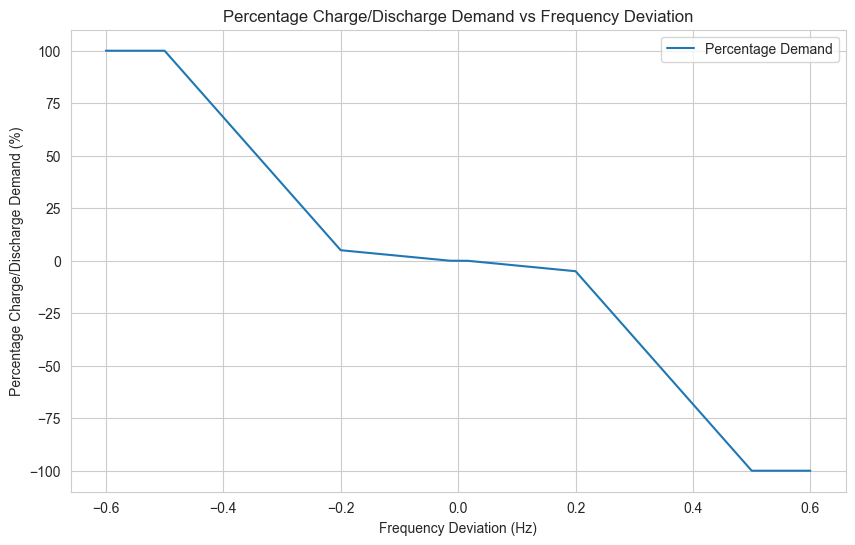

In [15]:
# Generate deviation values between -0.6 and 0.6
deviation_values = np.linspace(-0.6, 0.6, 1000)
demand_values = [
    calculate_power_demand(deviation, 100, "both", dc_conf)
    for deviation in deviation_values
]

# Plot the percentage demand vs deviation
plt.figure(figsize=(10, 6))
plt.plot(deviation_values, demand_values, label="Percentage Demand")
plt.xlabel("Frequency Deviation (Hz)")
plt.ylabel("Percentage Charge/Discharge Demand (%)")
plt.title("Percentage Charge/Discharge Demand vs Frequency Deviation")
plt.legend()
plt.grid(True)
plt.show()

# Monte Carlo Simulations

**Approach**

To evaluate the performance and sustainability of our battery under different power demand scenarios, we will use Monte Carlo simulations. This approach allows us to model the battery's behavior over time using synthetic data generated from the fitted normal distribution. By simulating numerous possible future states, we can estimate the likelihood of various outcomes and make more informed decisions.

We will define a function to carry out the simulations using our Battery class and Power Demand function defined earlier, the key steps will be: 

**Steps**

1. **Generate Synthetic Deviations:**
   - Using the parameters of the fitted distribution (mean and standard deviation), generate synthetic frequency deviations. These deviations will represent the possible fluctuations in grid frequency that the battery will need to respond to.

2. **Simulate Battery Behavior:**
   - For each time step, calculate the power demand based on the synthetic deviation and the dynamic containment configuration.
   - Update the state-of-charge (SoC) of the battery accordingly, either charging or discharging as required.
   - Track the SoC over the simulation duration, noting any instances where the battery hits its limits (either empty or full).
   - If the battery reaches a full or empty state, the simulation will end. 

3. **Perform Multiple Simulations:**
   - Repeat the simulation process multiple times (e.g., 1000 iterations would be nice but we will keep to 5 here for speed of running) to account for the inherent variability and uncertainty in the data.
   - Record the results of each simulation, including the total duration the battery can sustain the service without hitting limits and the power demand history.

4. **Analyze Results:**
   - Calculate the mean total duration across all simulations to determine the expected performance of the battery.
   - Identify the minimum and maximum power demand values encountered during the simulations.
   - Use these insights to evaluate the feasibility of different service power levels (2MW, 5MW, 10MW) and optimize the battery's operation strategy.




## Creating A Function To Perform the Monte Carlo Simulations

We wrote a quick funciton to actually perform the Monte Carlo simulations. Ideally, as with the other functions, this would live in an appropriate module in the repository with complete error handling and unit testing. But this is beyond the scope of this task. 

**Process**

1. **Initialization:**
   - Initialize a dictionary to store the results of each simulation.
   - For each simulation, create a new `Battery` instance starting at the specified initial state of charge.

2. **Simulate Time Steps:**
   - For each second in the simulation duration:
     - Generate a synthetic frequency deviation using the normal distribution parameters (`norm_params`).
     - Calculate the actual power demand based on the deviation, service power, service type, and dynamic containment configuration (`dc_conf`).
     - Update the battery's state of charge by either discharging or charging based on the power demand.
     - Record the state of charge and power demand for each time step.

3. **Handle Battery Limits:**
   - If the battery reaches its minimum or maximum state of charge, catch the corresponding exception (`EmptyBatteryException` or `FullBatteryException`) and record it.

4. **Store Simulation Results:**
   - Store the total duration, state of charge history, power demand history, and any exceptions encountered in the results dictionary.
   - If the save_state boolean function is set to false, these are not saved. This allows us to run many simulations without overloading our device memory as the state arrays are quite large, but we will obviously not be able to view these values over time. 


In [39]:
def monte_carlo_simulation(
    norm_params: Tuple[float, float],
    dc_conf: Dict[str, Any],
    service_power: float,
    service_type: str,
    initial_state_of_charge: float = 0.5,
    num_simulations: int = 5,
    duration_seconds: int = 3600,
    save_state: bool = True,
) -> Dict[int, Dict[str, Any]]:
    """
    Perform a Monte Carlo simulation to model battery power demand over time.

    Parameters
    ----------
    norm_params : Tuple[float, float]
        Mean and standard deviation for the normal distribution used to generate deviations.
    dc_conf : Dict[str, Any]
        Configuration settings for the dynamic containment.
    service_power : float
        The power requirement of the service in MW.
    service_type : str
        Type of service affecting the power demand calculation.
    initial_state_of_charge : float, optional
        Initial state of charge of the battery (percentage). Default is 0.5 (50%).
    num_simulations : int, optional
        Number of simulations to run. Default is 5.
    duration_seconds : int, optional
        Duration of each simulation in seconds. Default is 3600 (1 hour).
    save_state : bool, optional
        Whether to save the state at each step. Default is True.

    Returns
    -------
    Dict[int, Dict[str, Any]]
        A dictionary containing the results of each simulation. Each entry includes:
        - 'total_duration': Duration for which the battery operated in the simulation.
        - 'state_of_charge_history': List of state of charge values over the simulation duration (empty if save_state is False).
        - 'power_demand_history': List of power demand values over the simulation duration (empty if save_state is False).
        - 'ending_exception': Exception encountered when the battery state limits were reached (if any).
    """
    results = {}
    for sim_n in range(num_simulations):
        battery = Battery(initial_soc=initial_state_of_charge)
        duration = 0
        state_of_charge_history = []
        power_demand_history = []
        ending_exception = None
        for _ in range(duration_seconds):
            try:
                deviation = np.random.normal(norm_params[0], norm_params[1])
                actual_demand = calculate_power_demand(
                    deviation, service_power, service_type, dc_conf
                )
                if actual_demand > 0:
                    # Discharge
                    battery.discharge(
                        power_mw=actual_demand, duration_seconds=1
                    )  # 1-second interval
                else:
                    # Charge
                    battery.charge(
                        power_mw=-actual_demand, duration_seconds=1
                    )  # 1-second interval
                duration += 1
                if save_state:
                    state_of_charge_history.append(battery.get_state_of_charge())
                    power_demand_history.append(actual_demand)
            except (EmptyBatteryException, FullBatteryException) as e:
                ending_exception = e.__class__.__name__
                break
        results[sim_n] = {
            "total_duration": duration,
            "state_of_charge_history": state_of_charge_history if save_state else [],
            "power_demand_history": power_demand_history if save_state else [],
            "ending_exception": ending_exception,
        }
    return results

# Running Simulations and Collecting Results

Now that we have all of the compnents we need to run the analysis, we will take a structured approach to find answers to the brief's questions:

Assuming DC service as defined in Appendix A, produce a brief analysis showing:
1. The state-of-charge of the battery when running the ‘both’ DC service with
the three contracted powers given;
2. The longest time we can expect to run a DC service without either running
out of energy, hitting a full state-of-charge, or hitting power limits;
3. Your informed opinions on running high, low, both services with different
battery sizes: what service would you recommend with this battery?


**Simulation Parameters**

We set the parameters for each simulation with some constants before running. 

- **service_powers** = [2, 5, 10] <- The prescribed service power levels. 
- **seconds_per_year** = 365 * 24 * 60 * 60 <- We initially decided to run the simulations for 1 year
- **service_type** = "both" <- The service type to simulate
- **initial_soc** = 0.5 <- The initial battery state of charge can be changed based on the service type needs and what we see in the simulations. 
- **num_simulations** = 5 <- Ideally we would run thousands of simulations with parallelisation/multi threading but this is time consuming and out of scope for the time allocated for this task but totally doable!

The battery parameters were left at the class' default values (the values prescribed in the brief) but we could also tweak these if we really wanted to, but again this is out of scope. 

## **Analysis**

We will create visualisations and perform analysis as we progress through this section in the notebook as  this makes it easier to follow. We have included a full analysis here also. 


**1. The state-of-charge of the battery when running the ‘both’ DC service with
the three contracted powers given;**

The result of the analysis can be seen in section 8.1 and 8.2 below. 

- At all service power levels, the mean SOC gradually declines over time. This is due to the charging losses experienced by the battery, even though it is being charged and discharged at approximately equal rates according to our deviation distribution.
- There is significant variation in the SOC trajectories across the 5 simulations at each power level. This highlights the stochastic nature of the battery's operation, as it responds to the random deviations generated from our fitted distribution.

- The variation in SOC trajectories appears to be more pronounced at higher service power levels. This is likely due to the large increase in service power relative to the battery capacity at 5MW and 10MW.

- The rate of SOC decline is directly related to the service power level as would be expected. 

Sure! Here's the answer in markdown format:

**2. The longest time we can expect to run a DC service without either running out of energy, hitting a full state-of-charge, or hitting power limits;**

Based on the assumptions of our model and simulations, using only 5 simulations, when commencing the battery SOC at 99% we are able to achieve:

| Service Power | Mean Duration to Reach 0% SOC over 5 simulations |
|---------------|--------------------------------------------------|
| 2 MW          | 324.94 days                                      |
| 5 MW          | 129.56 days                                      |
| 10 MW         | 64.86 days                                       |


In an ideal world, we would repeat these simulations thousands of times to get a more accurate estimate of the mean duration and to better understand the distribution of possible outcomes. Repeating the simulations many times provides several benefits:

- **Improved accuracy**: By running a large number of simulations, we can obtain a more precise estimate of the mean duration to reach 0% SOC for each service power level. This is because the influence of random variations in individual simulations is reduced when averaged over a larger sample size.

- **Confidence intervals**: With a large number of simulations, we can calculate ranges of durations for each service power level at different confidence intervals. This allows us to quantify the uncertainty associated with our estimates and provide stakeholders with a range of plausible values. For example, we could report that for the 2 MW service power, we are 90% confident that the duration to reach 0% SOC falls between X and Y days.

- **Understanding variability**: Conducting many simulations allows us to quantify the variability in the battery's performance. We can calculate measures such as standard deviation or percentiles to understand the range of possible durations and the likelihood of extreme outcomes.

- **Robustness to outliers**: With a larger number of simulations, the impact of outliers or unusual scenarios on the overall results is minimized. This ensures that our conclusions are based on the typical behavior of the system rather than being skewed by rare events.

Running thousands of simulations could be easily achieved with a slight refactor of the monte carlo simulation function to enable the use of multi threading. This, combined with an EC2 instance with many CPUs would enable us to quickly run thousands of simulations. We are capable of doing that, but didn't due to time constraints. 


- **Prediction and Confidence Intervals Process**

```
# Calculate the 95% prediction interval using percentiles. 95% of service durations should lie within this range
lower_bound = np.percentile(service_durations, 2.5)
upper_bound = np.percentile(service_durations, 97.5)

# Calculate the mean
mean_duration = np.mean(service_durations)

# Calculate the standard deviation
std_dev_duration = np.std(service_durations, ddof=1)

# Critical value for 95% confidence interval
z = stats.norm.ppf(0.975)  # 95% confidence -> two-tailed test, so 0.975

# Number of simulations
n = len(sample_data)

# Standard error
std_error = std_dev_duration / np.sqrt(n)

# Margin of error
margin_of_error = z * std_error

# Confidence interval, The mean service duration will lie within this range 95% of the time
lower_bound = mean_duration - margin_of_error
upper_bound = mean_duration + margin_of_error
```

**Hitting Power Limits**

During our simulations, we found that both the 2MW and 5MW services can be safely run for an extended period without running into power limitations (either charging or discharging) of our battery. However, the 5MW *could* run into power limitations as the full service power is greater than our battery's maximum charge rate. Similarly, the 10MW DID run into a power limitation where the requested input from the grid exceeded the available power from our battery. It's not clear what the concequences of this would be from the brief, but we should carefully consider whether we can or should offer 5MW and 10MW services when we know there is a chance we may not be able to meet demand.

If we had more time, we would use statistical methods to estimate the probabilities of a power limitation event for each of these services. This could be done by calculating the frequency deviation that would cause a power limitation at a given service power, then calculate the probability of seeing such a deviation using our distributions 'CDF'. 

We could also calculate a service power at which we were 99.9% confident we would not see any failures. 

**3. Your informed opinions on running high, low, both services with different
battery sizes: what service would you recommend with this battery?**

From the below simulations it's clear that:

- A 'Both' service will inevitably result in an empty battery due to charging losses over a long period of time.
- A 'High' service will inevitably result in a full battery within days.
- A 'Low' service will inevitably result in an empty battery within days.

We see little benefit of running a 'low' service when a 'both' service seems to be able to handle all of the simulated charge and discharge demand. However, if we had several batteries we *could* offer both 'High' and 'Both' services in conjunction:Rotating batteries to allow adequate time for the 'Both service to discharge our battery, then switch it to a 'high' service to recoup the lost charge. With some optimisation, this would allow us to meet all of the grids demands whilst never incurring an empty or full SOC in the battery. 

## Simulating a 'Both' Service Within Initial 50% SOC.

We started by simulating a 'both' service, beginning the simulations with a battery state of 50%. 

We thought this was logical as this service would both discharge and charge the battery. As the mean of our normally distributed frequency deviations slightly above 0, we felt this should maintain a charge level of around 50% and slowly drop away due to the batteries' charging efficiency loss.

What we found that the battery SOC actually drops away much more quickly that anticipated, particularly for the higher service powers. 

While should be, on average due to the distribution of the frequency deviations, charging more often than discharging. The efficiency loss means that we are consistently losing battery charge.

The battery was completely discharged at:

- 2MW = 164 Days
- 5MW = 65 Days
- 10MW = 32 Days

In [17]:
# Run Monte Carlo simulations for different power levels
service_powers = [2, 5, 10]
seconds_per_year = 365 * 24 * 60 * 60
service_type = "both"
initial_soc = 0.5
num_simulations = 5

both_50_simulation_results = {}
for sp in service_powers:
    both_50_simulation_results[sp] = monte_carlo_simulation(
        norm_params=norm_params,
        initial_state_of_charge=initial_soc,
        dc_conf=dc_conf,
        service_power=sp,
        service_type=service_type,
        num_simulations=num_simulations,
        duration_seconds=seconds_per_year,
    )

/var/folders/b4/srbwjb_15l385gv424rwz_4ncl71gk/T/ipykernel_48915/1333075598.py:15: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  timestamps = pd.date_range(start='2024-07-01', periods=len(sim_result['state_of_charge_history']), freq='S')
/var/folders/b4/srbwjb_15l385gv424rwz_4ncl71gk/T/ipykernel_48915/1333075598.py:37: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])  # Adjust subplot spacing


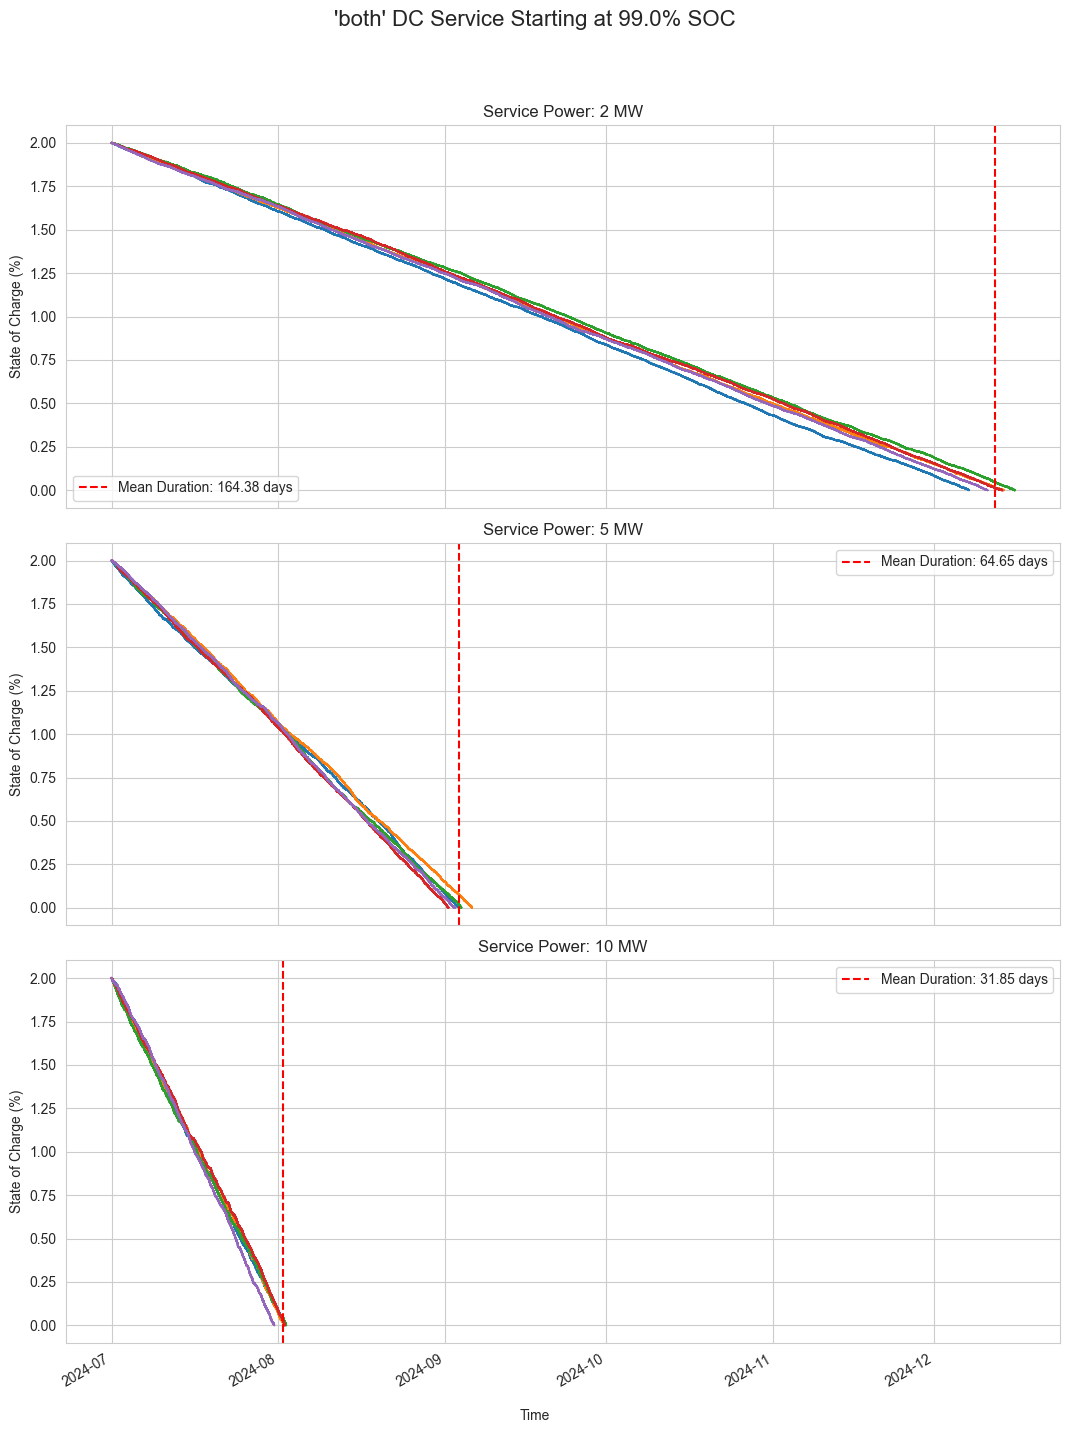

In [29]:
simulation_results = both_50_simulation_results

# Calculate mean total duration in seconds and convert to days
mean_durations = {
    sp: np.mean([res["total_duration"] for res in simulation_results[sp].values()])
    for sp in service_powers
}
mean_duration_days = {sp: mean_durations[sp] / (24 * 3600) for sp in service_powers}

# Create a figure with subplots for each service power
fig, axs = plt.subplots(len(service_powers), 1, figsize=(12, 15), sharex=True)

# Iterate over each service power level
for i, sp in enumerate(service_powers):
    # Iterate over each simulation result for the current service power
    for sim_result in simulation_results[sp].values():
        # Convert the index to timestamps for better x-axis labeling
        timestamps = pd.date_range(
            start="2024-07-01",
            periods=len(sim_result["state_of_charge_history"]),
            freq="S",
        )
        axs[i].plot(timestamps, sim_result["state_of_charge_history"])

    # Add mean total duration vertical line
    mean_duration_timestamp = pd.to_datetime("2024-07-01") + pd.Timedelta(
        days=mean_duration_days[sp]
    )
    axs[i].axvline(
        x=mean_duration_timestamp,
        color="red",
        linestyle="--",
        label=f"Mean Duration: {mean_duration_days[sp]:.2f} days",
    )

    axs[i].set_title(f"Service Power: {sp} MW")
    axs[i].set_ylabel("State of Charge (%)")
    axs[i].legend()

# Set x-axis label and rotate x ticks for better readability
fig.text(0.5, 0.04, "Time", ha="center")
# fig.text(0.04, 0.5, 'State of Charge (%)', va='center', rotation='vertical')

# Set super title
fig.suptitle(
    f"'{service_type}' DC Service Starting at {initial_soc *100}% SOC", fontsize=16
)

# Rotate x-axis labels and format dates
fig.autofmt_xdate()

# Adjust layout and display the plot
plt.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])  # Adjust subplot spacing
plt.show()

## Simulating a 'Both' Service Within Initial 99% SOC.

**SOC over time**

Due to our 'both' service and charging inefficiencies resulting in consistent battery drain, we decided to commence the service at a 99% SOC. 

We found that this significantly improved the maximum time we can expect to run a DC 'both' service. It also did not result in any of the simulations reaching a full SOC of the battery.

This should be caveated by the fact our simulation ignores the smaller patterns and trends in frequency deviations described earlier, where by we may see sustained battery discharge or charge for a few hours. It may not actually be safe to commence a service at 99% state of charge and we may need to reduce this slightly. 

We can also see that there is some deviation in the total duration of the simulations for each power which are +/- a few days.  

Starting at 99% SOC battery was on average completely discharged at:

- **2MW = 323 Days**
- **5MW = 128 Days**
- **10MW = 65 Days**

**Power Demands**

We later looked at the power demands for each of the service levels at each service power. Our battery has limitations to the rate it can charge and discharge and an important consideration as to whether or not we can offer a given service power is whether we can actually deliver the likely required power. 

- **2MW** service is well below both our charge and discharge limit and unsurprisingly the maximum loads were well within tolerances:
    - Min Demand: -1.02 MW <- This is charging the battery at 1.02MW 
    - Max Demand: 0.98 MW <- This is discharging the battery
- **5MW** service could potentially cause issues as our maximum charge rate is 4MW / 0.9 = 4.44MW. However, as we have seen from our distribution of estimated demand, reaching a frequency deviation of +/-0.5hz and requiring maximum load is very unlikely. The demand seen in the simulations was well within these limits.
    - Min Demand: -2.55 MW
    - Max Demand: 2.29 MW
- **10MW** service may well cause some issues as this power is double our batteries' maximum discharge rate/charge rate. In our simulations we found that we would have reached a state where our battery was unable to receive the required energy from the grid as per the DC service but it was able to meet the discharge demand. 
    - Min Demand: -4.50 MW <- **This is greated than our maximum charge rate and may cause damage or failure to provide contracted service.**
    - Max Demand: 4.51 MW <- This is within our battery's limits

In [28]:
# Run Monte Carlo simulations for different power levels
service_powers = [2, 5, 10]
seconds_per_year = 365 * 24 * 60 * 60
service_type = "both"
initial_soc = 0.99
num_simulations = 5

both_99_simulation_results = {}
for sp in service_powers:
    both_99_simulation_results[sp] = monte_carlo_simulation(
        norm_params=norm_params,
        initial_state_of_charge=initial_soc,
        dc_conf=dc_conf,
        service_power=sp,
        service_type=service_type,
        num_simulations=num_simulations,
        duration_seconds=seconds_per_year,
    )

/var/folders/b4/srbwjb_15l385gv424rwz_4ncl71gk/T/ipykernel_48915/3863052145.py:15: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  timestamps = pd.date_range(start='2024-07-01', periods=len(sim_result['state_of_charge_history']), freq='S')
/var/folders/b4/srbwjb_15l385gv424rwz_4ncl71gk/T/ipykernel_48915/3863052145.py:37: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])  # Adjust subplot spacing


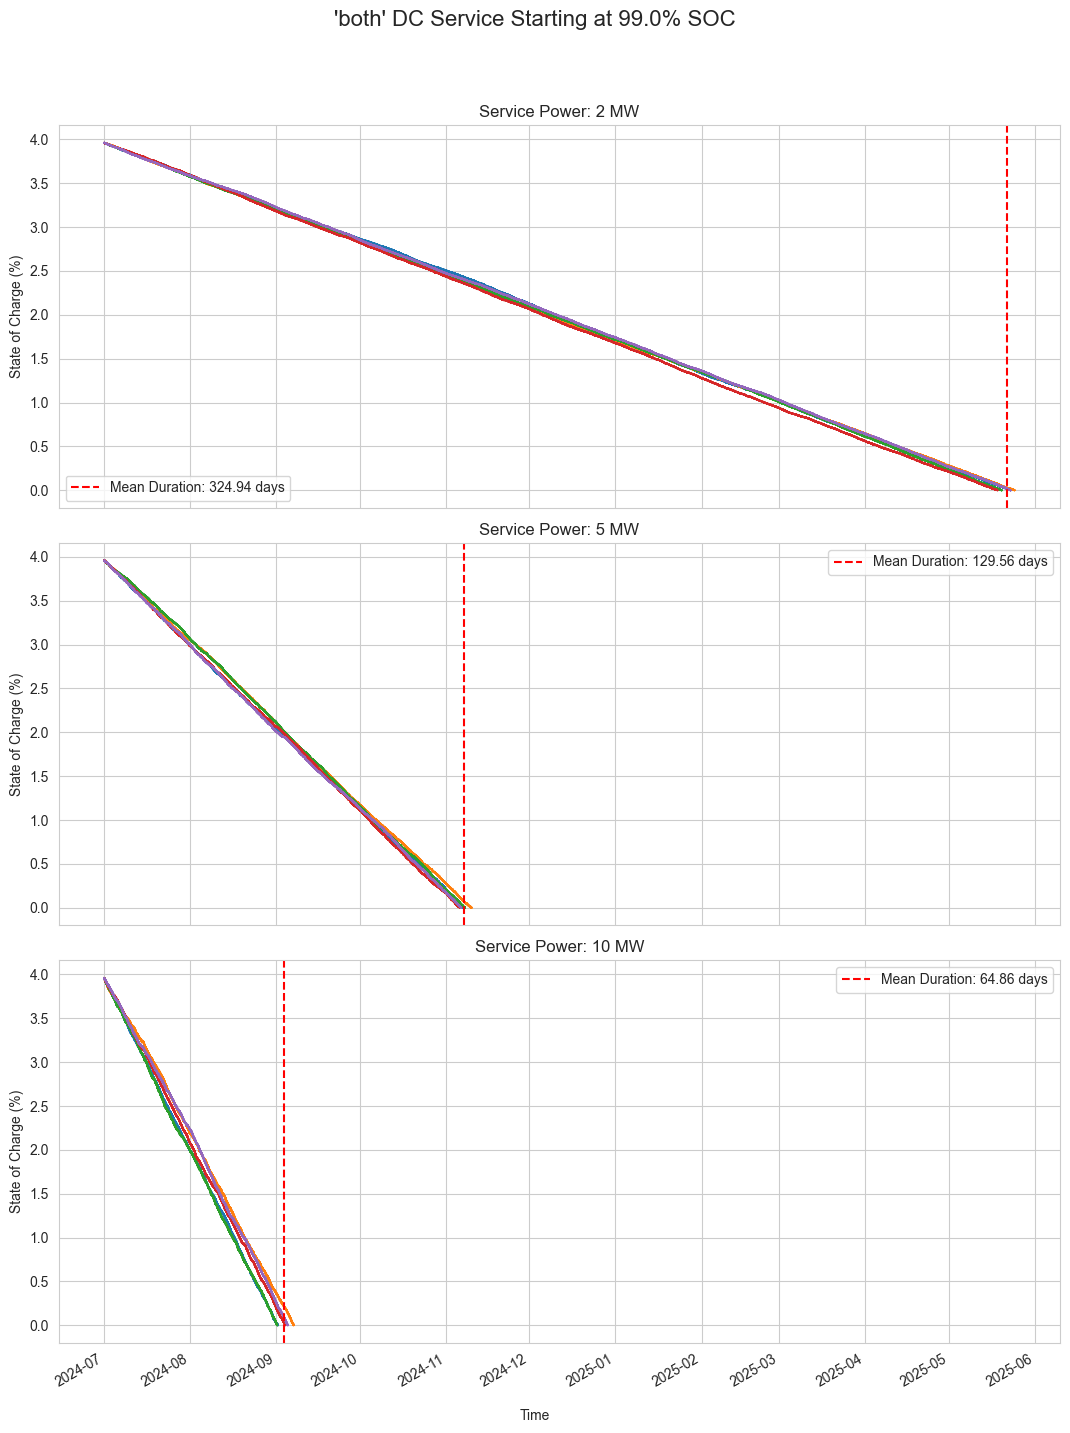

In [20]:
simulation_results = both_99_simulation_results

# Calculate mean total duration in seconds and convert to days
mean_durations = {
    sp: np.mean([res["total_duration"] for res in simulation_results[sp].values()])
    for sp in service_powers
}
mean_duration_days = {sp: mean_durations[sp] / (24 * 3600) for sp in service_powers}

# Create a figure with subplots for each service power
fig, axs = plt.subplots(len(service_powers), 1, figsize=(12, 15), sharex=True)

# Iterate over each service power level
for i, sp in enumerate(service_powers):
    # Iterate over each simulation result for the current service power
    for sim_result in simulation_results[sp].values():
        # Convert the index to timestamps for better x-axis labeling
        timestamps = pd.date_range(
            start="2024-07-01",
            periods=len(sim_result["state_of_charge_history"]),
            freq="S",
        )
        axs[i].plot(timestamps, sim_result["state_of_charge_history"])

    # Add mean total duration vertical line
    mean_duration_timestamp = pd.to_datetime("2024-07-01") + pd.Timedelta(
        days=mean_duration_days[sp]
    )
    axs[i].axvline(
        x=mean_duration_timestamp,
        color="red",
        linestyle="--",
        label=f"Mean Duration: {mean_duration_days[sp]:.2f} days",
    )

    axs[i].set_title(f"Service Power: {sp} MW")
    axs[i].set_ylabel("State of Charge (%)")
    axs[i].legend()

# Set x-axis label and rotate x ticks for better readability
fig.text(0.5, 0.04, "Time", ha="center")
# fig.text(0.04, 0.5, 'State of Charge (%)', va='center', rotation='vertical')

# Set super title
fig.suptitle(
    f"'{service_type}' DC Service Starting at {initial_soc *100}% SOC", fontsize=16
)

# Rotate x-axis labels and format dates
fig.autofmt_xdate()

# Adjust layout and display the plot
plt.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])  # Adjust subplot spacing
plt.show()

### Visualising Power demand for each simulation

/var/folders/b4/srbwjb_15l385gv424rwz_4ncl71gk/T/ipykernel_48915/1167846058.py:14: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  timestamps = pd.date_range(start='2023-01-01', periods=len(sim_result['state_of_charge_history']), freq='S')
/var/folders/b4/srbwjb_15l385gv424rwz_4ncl71gk/T/ipykernel_48915/1167846058.py:33: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()


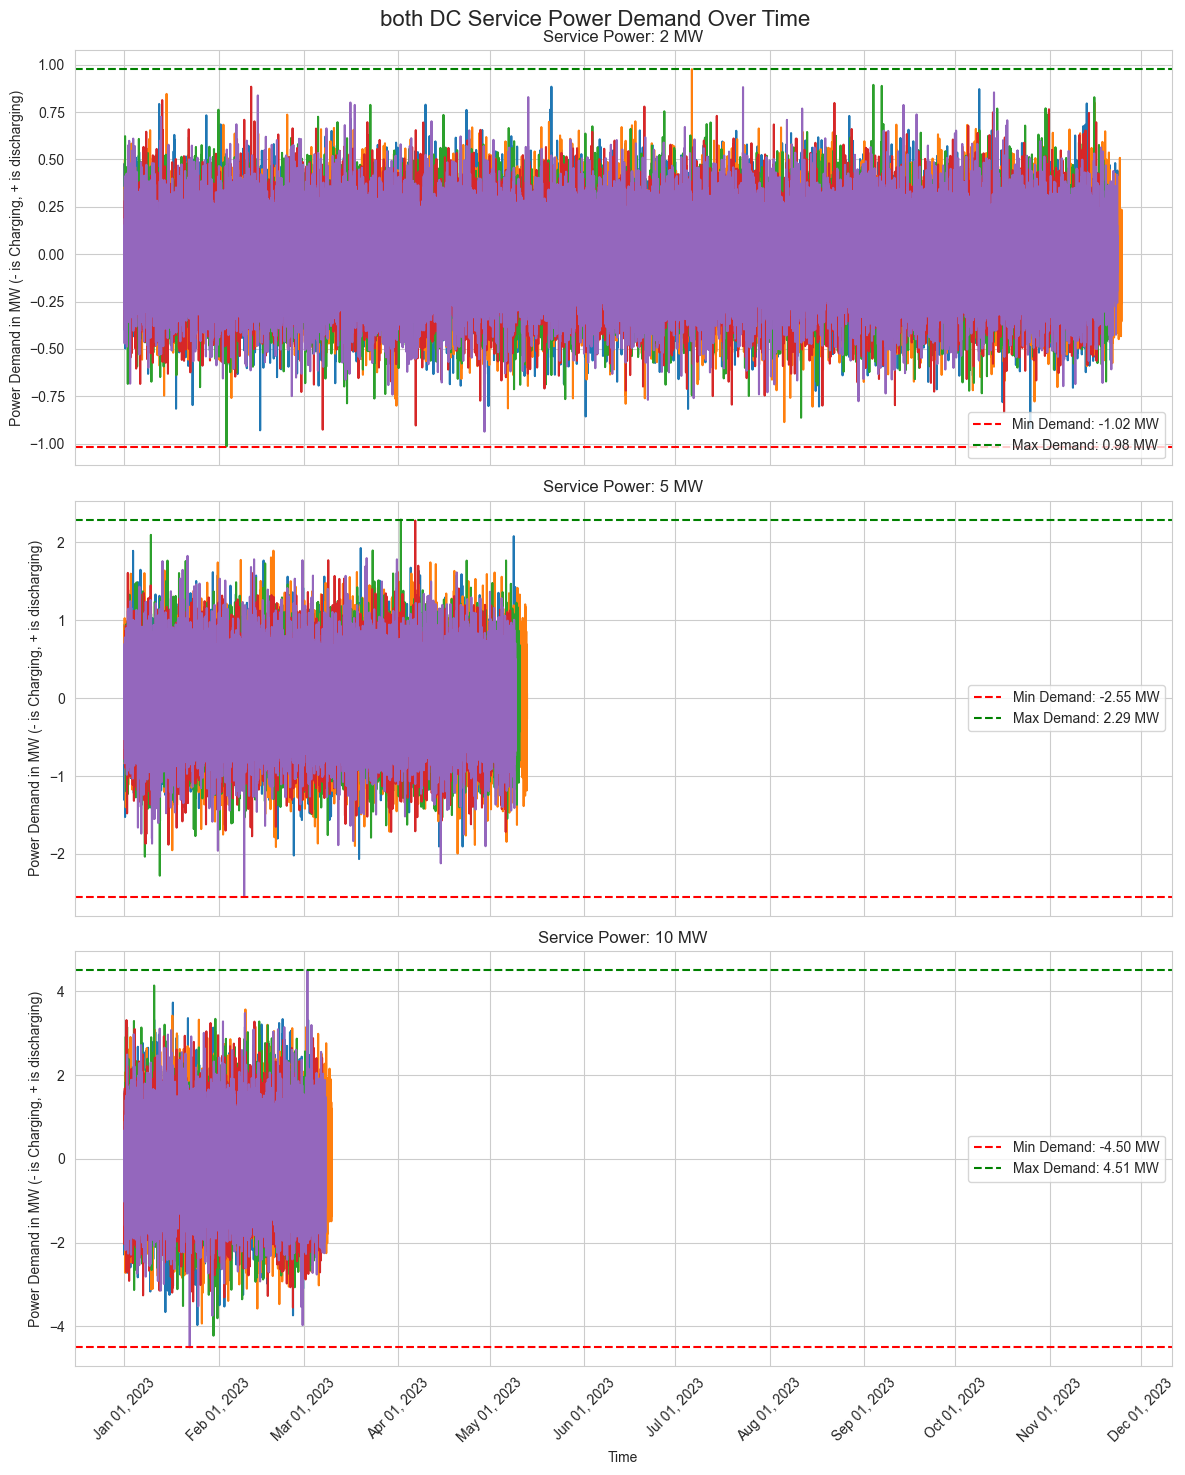

In [21]:
# Calculate min and max power demand for each service power
min_max_demands = {
    sp: (
        min(
            [
                min(res["power_demand_history"])
                for res in simulation_results[sp].values()
            ]
        ),
        max(
            [
                max(res["power_demand_history"])
                for res in simulation_results[sp].values()
            ]
        ),
    )
    for sp in service_powers
}

# Create a figure with subplots for each service power
fig, axs = plt.subplots(len(service_powers), 1, figsize=(12, 15), sharex=True)

# Iterate over each service power level
for i, sp in enumerate(service_powers):
    # Iterate over each simulation result for the current service power
    for sim_result in simulation_results[sp].values():
        # Convert the index to timestamps for better x-axis labeling
        timestamps = pd.date_range(
            start="2023-01-01",
            periods=len(sim_result["state_of_charge_history"]),
            freq="S",
        )
        axs[i].plot(timestamps, sim_result["power_demand_history"])

    # Add horizontal lines for min and max power demand values
    min_demand, max_demand = min_max_demands[sp]
    axs[i].axhline(
        y=min_demand,
        color="red",
        linestyle="--",
        label=f"Min Demand: {min_demand:.2f} MW",
    )
    axs[i].axhline(
        y=max_demand,
        color="green",
        linestyle="--",
        label=f"Max Demand: {max_demand:.2f} MW",
    )

    axs[i].set_title(f"Service Power: {sp} MW")
    axs[i].set_ylabel("Power Demand in MW (- is Charging, + is discharging)")
    axs[i].legend()

# Set x-axis label only on the bottom subplot and rotate x ticks for better readability
axs[-1].set_xlabel("Time")
axs[-1].xaxis.set_major_formatter(mdates.DateFormatter("%b %d, %Y"))
plt.xticks(rotation=45)
fig.suptitle(f"{service_type} DC Service Power Demand Over Time", fontsize=16)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

## Simulating a 'High' Service Within Initial 1% SOC.

**SOC over time**

As our battery will not be discharging at all, we decided to start the service at 1% SOC.

We found that the battery very quickly reaches a full state of charge when there is no discharging at all which is not surprising in itself, but the rate at which it happened was. 

It was also noteworthy that the 5 simulations were had very little deviation in end result or SOC over time. This is likely due to us halving the posible variance in frequency deviations that impact the SOC of our battery. 

The battery reached a full SOC at 

- **2MW = 19.23 Days**
- **5MW = 7.69 Days**
- **10MW = 3.84 Days**

**Power Demands**

We did re-plot the power demands for the 'high' service but as we found no significant difference between the demand of the 'high' service and the negative demand seen in the 'both' service plot above. Removed for brevity/readability. 


In [32]:
# Run Monte Carlo simulations for different power levels
service_powers = [2, 5, 10]
seconds_per_year = 365 * 24 * 60 * 60
service_type = "high"
initial_soc = 0.01
num_simulations = 5

high_99_simulation_results = {}
for sp in service_powers:
    high_99_simulation_results[sp] = monte_carlo_simulation(
        norm_params=norm_params,
        initial_state_of_charge=initial_soc,
        dc_conf=dc_conf,
        service_power=sp,
        service_type=service_type,
        num_simulations=num_simulations,
        duration_seconds=seconds_per_year,
    )

/var/folders/b4/srbwjb_15l385gv424rwz_4ncl71gk/T/ipykernel_48915/503725700.py:15: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  timestamps = pd.date_range(start='2024-07-01', periods=len(sim_result['state_of_charge_history']), freq='S')


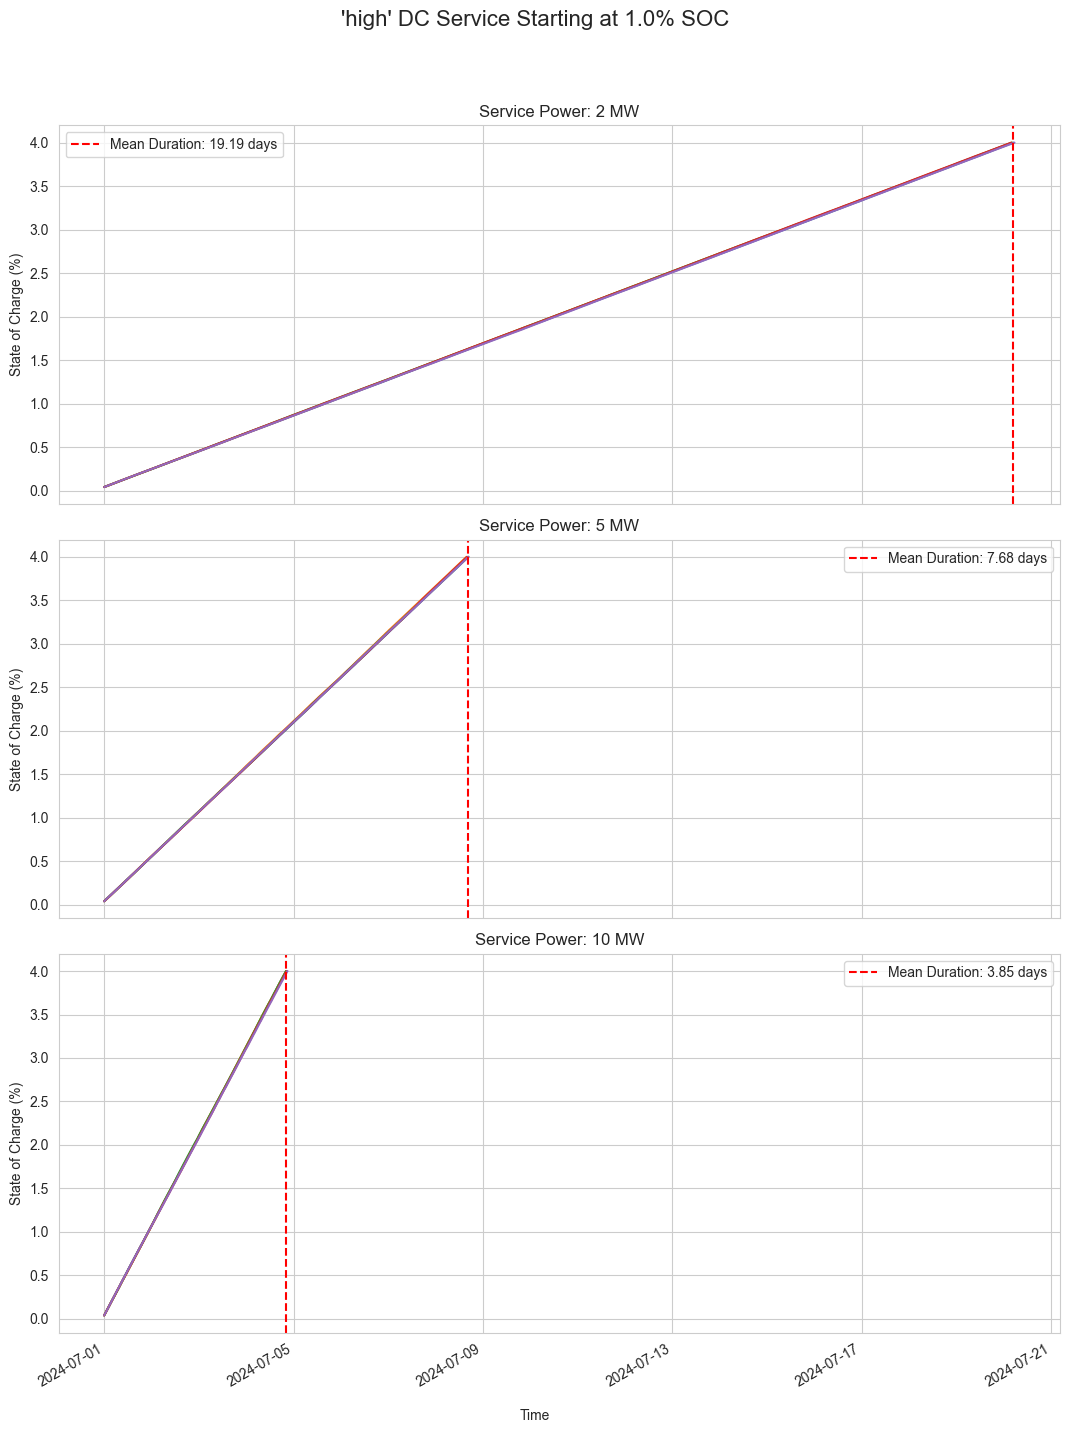

In [33]:
simulation_results = high_99_simulation_results

# Calculate mean total duration in seconds and convert to days
mean_durations = {
    sp: np.mean([res["total_duration"] for res in simulation_results[sp].values()])
    for sp in service_powers
}
mean_duration_days = {sp: mean_durations[sp] / (24 * 3600) for sp in service_powers}

# Create a figure with subplots for each service power
fig, axs = plt.subplots(len(service_powers), 1, figsize=(12, 15), sharex=True)

# Iterate over each service power level
for i, sp in enumerate(service_powers):
    # Iterate over each simulation result for the current service power
    for sim_result in simulation_results[sp].values():
        # Convert the index to timestamps for better x-axis labeling
        timestamps = pd.date_range(
            start="2024-07-01",
            periods=len(sim_result["state_of_charge_history"]),
            freq="S",
        )
        axs[i].plot(timestamps, sim_result["state_of_charge_history"])

    # Add mean total duration vertical line
    mean_duration_timestamp = pd.to_datetime("2024-07-01") + pd.Timedelta(
        days=mean_duration_days[sp]
    )
    axs[i].axvline(
        x=mean_duration_timestamp,
        color="red",
        linestyle="--",
        label=f"Mean Duration: {mean_duration_days[sp]:.2f} days",
    )

    axs[i].set_title(f"Service Power: {sp} MW")
    axs[i].set_ylabel("State of Charge (%)")
    axs[i].legend()

# Set x-axis label and rotate x ticks for better readability
fig.text(0.5, 0.04, "Time", ha="center")
# fig.text(0.04, 0.5, 'State of Charge (%)', va='center', rotation='vertical')

# Set super title
fig.suptitle(
    f"'{service_type}' DC Service Starting at {initial_soc *100}% SOC", fontsize=16
)

# Rotate x-axis labels and format dates
fig.autofmt_xdate()

# Adjust layout and display the plot
plt.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])  # Adjust subplot spacing
plt.show()

## Simulating a 'Low' Service With Initial 99% SOC.

**SOC over time**

As our battery will not be charging at all, we decided to start the service at 99% SOC.

We found that the battery very quickly reaches an empty state of charge when there is no charging at all (again, somewhat obvious). 

We saw that the rate at which the battery discharges is slightly higher than the rate at which it charges. This is consistent with both the estimated distribution of frequency deviations (the mean of which is close to 0) and the efficiency loss when charging the battery of 10% vs the 0% discharge loss. 

Again, the 5 simulations were had very little deviation in end result or SOC over time. T

The battery reached an empty SOC at 

- **2MW = 18.14 Days**
- **5MW = 7.25 Days**
- **10MW = 3.63 Days**

**Power Demands**

Again, we did not replot this as it was almost identical to the positive part of the 'both' service plot.


In [35]:
# Run Monte Carlo simulations for different power levels
service_powers = [2, 5, 10]
seconds_per_year = 365 * 24 * 60 * 60
service_type = "low"
initial_soc = 0.99
num_simulations = 5

low_99_simulation_results = {}
for sp in service_powers:
    low_99_simulation_results[sp] = monte_carlo_simulation(
        norm_params=norm_params,
        initial_state_of_charge=initial_soc,
        dc_conf=dc_conf,
        service_power=sp,
        service_type=service_type,
        num_simulations=num_simulations,
        duration_seconds=seconds_per_year,
    )

/var/folders/b4/srbwjb_15l385gv424rwz_4ncl71gk/T/ipykernel_48915/2956721288.py:15: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  timestamps = pd.date_range(start='2024-07-01', periods=len(sim_result['state_of_charge_history']), freq='S')


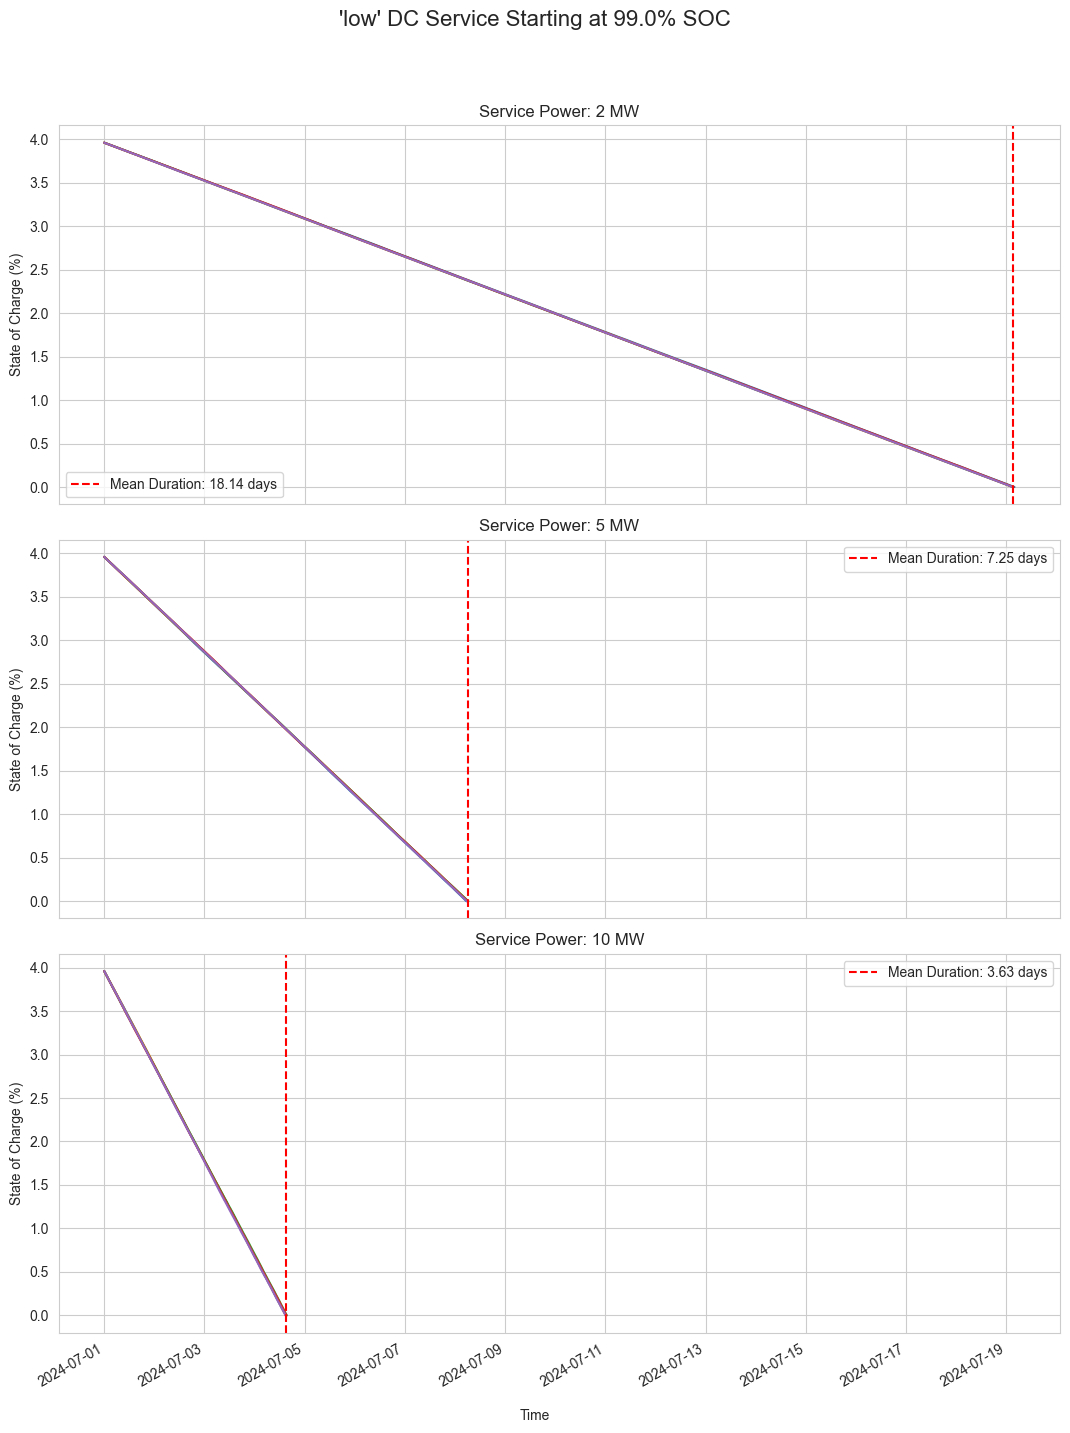

In [36]:
simulation_results = low_99_simulation_results

# Calculate mean total duration in seconds and convert to days
mean_durations = {
    sp: np.mean([res["total_duration"] for res in simulation_results[sp].values()])
    for sp in service_powers
}
mean_duration_days = {sp: mean_durations[sp] / (24 * 3600) for sp in service_powers}

# Create a figure with subplots for each service power
fig, axs = plt.subplots(len(service_powers), 1, figsize=(12, 15), sharex=True)

# Iterate over each service power level
for i, sp in enumerate(service_powers):
    # Iterate over each simulation result for the current service power
    for sim_result in simulation_results[sp].values():
        # Convert the index to timestamps for better x-axis labeling
        timestamps = pd.date_range(
            start="2024-07-01",
            periods=len(sim_result["state_of_charge_history"]),
            freq="S",
        )
        axs[i].plot(timestamps, sim_result["state_of_charge_history"])

    # Add mean total duration vertical line
    mean_duration_timestamp = pd.to_datetime("2024-07-01") + pd.Timedelta(
        days=mean_duration_days[sp]
    )
    axs[i].axvline(
        x=mean_duration_timestamp,
        color="red",
        linestyle="--",
        label=f"Mean Duration: {mean_duration_days[sp]:.2f} days",
    )

    axs[i].set_title(f"Service Power: {sp} MW")
    axs[i].set_ylabel("State of Charge (%)")
    axs[i].legend()

# Set x-axis label and rotate x ticks for better readability
fig.text(0.5, 0.04, "Time", ha="center")
# fig.text(0.04, 0.5, 'State of Charge (%)', va='center', rotation='vertical')

# Set super title
fig.suptitle(
    f"'{service_type}' DC Service Starting at {initial_soc *100}% SOC", fontsize=16
)

# Rotate x-axis labels and format dates
fig.autofmt_xdate()

# Adjust layout and display the plot
plt.tight_layout(rect=[0.05, 0.05, 0.95, 0.95])  # Adjust subplot spacing
plt.show()